In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from utils import get_dataset

In [2]:
def create_model(input_raster_shape=(100, 100, 1), climate_vars=8):
    # Input for the raster (100x100 grid)
    raster_input = Input(shape=input_raster_shape)

    # Convolutional layers for the raster input: spatial feature extraction
    x = Conv2D(32, (3, 3), activation='relu')(raster_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)  # Flatten for concat

    # Input: climate variables
    climate_input = Input(shape=(climate_vars,))

    # Dense layers for the climate variables input
    climate_dense = Dense(32, activation='relu')(climate_input)
    climate_dense = Dense(16, activation='relu')(climate_dense)

    # Concat spatial features + climate features
    combined = Concatenate()([x, climate_dense])

    # FC after
    combined_dense = Dense(128, activation='relu')(combined)
    output = Dense(100 * 100, activation='sigmoid')(combined_dense)  # Output flattened raster

    final_model = Model(inputs=[raster_input, climate_input], outputs=output)
    final_model.compile(optimizer='adam', loss='mean_squared_error')

    return final_model

In [ ]:
def create_model_2(input_raster_shape=(100, 100, 1), climate_vars=8):
    # Input for the raster (100x100 grid)
    raster_input = Input(shape=input_raster_shape)

    # Convolutional layers for the raster input: spatial feature extraction
    x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(raster_input)
    x = BatchNormalization()(x)  # Batch Normalization
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)  # Dropout

    x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)  # Batch Normalization
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)  # Dropout

    x = Flatten()(x)  # Flatten for concat

    # Input: climate variables
    climate_input = Input(shape=(climate_vars,))

    # Dense layers for the climate variables input
    climate_dense = Dense(32, activation='relu')(climate_input)
    climate_dense = Dropout(0.25)(climate_dense)  # Dropout
    climate_dense = Dense(16, activation='relu')(climate_dense)
    climate_dense = Dropout(0.25)(climate_dense)  # Dropout

    # Concat spatial features + climate features
    combined = Concatenate()([x, climate_dense])

    # Fully connected layer after concatenation
    combined_dense = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(combined)
    combined_dense = Dropout(0.5)(combined_dense)  # Dropout

    # Output flattened raster
    output = Dense(100 * 100, activation='sigmoid')(combined_dense)

    final_model = Model(inputs=[raster_input, climate_input], outputs=output)
    final_model.compile(optimizer='adam', loss='mean_squared_error')

    return final_model

In [38]:
def create_model_3(input_raster_shape=(100, 100, 1), climate_vars=8):
    # Input for the raster (100x100 grid)
    raster_input = Input(shape=input_raster_shape)

    # Convolutional layers for the raster input: spatial feature extraction
    x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(raster_input)
    x = BatchNormalization()(x)  # Batch Normalization
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.15)(x)  # Dropout

    x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)  # Batch Normalization
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.15)(x)  # Dropout

    x = Flatten()(x)  # Flatten for concat

    # Input: climate variables
    climate_input = Input(shape=(climate_vars,))

    # Dense layers for the climate variables input
    climate_dense = Dense(32, activation='relu')(climate_input)
    climate_dense = Dropout(0.15)(climate_dense)  # Dropout
    climate_dense = Dense(16, activation='relu')(climate_dense)
    climate_dense = Dropout(0.15)(climate_dense)  # Dropout

    # Concat spatial features + climate features
    combined = Concatenate()([x, climate_dense])

    # Fully connected layer after concatenation
    combined_dense = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(combined)
    combined_dense = Dropout(0.25)(combined_dense)  # Dropout

    # Output flattened raster
    output = Dense(100 * 100, activation='sigmoid')(combined_dense)

    final_model = Model(inputs=[raster_input, climate_input], outputs=output)
    final_model.compile(optimizer='adam', loss='mean_squared_error')

    return final_model

In [3]:
def process_cnn_fire(sub_df):
    X_raster = []
    X_climate_vars = []
    y_raster = []
    for i in range(len(sub_df) - 1):
        X_raster.append(sub_df.raster[i])
        X_climate_vars.append([
            sub_df.burning_index[i], 
            sub_df.evapotranspiration_al[i], 
            sub_df.fuel_moisture_1000[i], 
            sub_df.relative_humidity_max[i], 
            sub_df.specific_humidity[i], 
            sub_df.temperature_max[i], 
            sub_df.vpd[i], 
            sub_df.wind_speed[i]
        ])
        y_raster.append(sub_df.raster_flat[i + 1])
    return X_raster, X_climate_vars, y_raster

def prepare_data_cnn(df):
    all_X = []
    all_climate = []
    all_y = []
    
    for fire in list(df.FIRE_NAME.unique()):
        sub_df = df[df.FIRE_NAME == fire].reset_index(drop=True)
        X, climate, y = process_cnn_fire(sub_df)
        all_X.extend(X)
        all_climate.extend(climate)
        all_y.extend(y)
    
    return all_X, all_climate, all_y

In [4]:
df = get_dataset("../data/dataset.csv")
X_cnn, climate_cnn, y_cnn = prepare_data_cnn(df)

In [5]:
X_cnn = np.array(X_cnn)
climate_cnn = np.array(climate_cnn)
y_cnn = np.array(y_cnn)

In [6]:
scaler_climate = MinMaxScaler()
climate_cnn_scaled = scaler_climate.fit_transform(climate_cnn)
X_train, X_test, climate_train, climate_test, y_train, y_test = train_test_split(
    X_cnn, climate_cnn_scaled, y_cnn, test_size=0.2, random_state=42)

print(f"Training set shapes: X_train={X_train.shape}, climate_train={climate_train.shape}, y_train={y_train.shape}")
print(f"Test set shapes: X_test={X_test.shape}, climate_test={climate_test.shape}, y_test={y_test.shape}")

Training set shapes: X_train=(4341, 100, 100), climate_train=(4341, 8), y_train=(4341, 10000)
Test set shapes: X_test=(1086, 100, 100), climate_test=(1086, 8), y_test=(1086, 10000)


In [7]:
model = create_model(input_raster_shape=(100, 100, 1), climate_vars=8)
model.summary()

history = model.fit(
    [X_train, climate_train],
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=([X_test, climate_test], y_test)
)
model.save("non_lstm_test_v1.keras")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 98, 98,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 49, 49,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 47, 47,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 23, 23,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        288 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 33856)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 33872)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  4,335,744 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10000)     │  1,290,000 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,645,376 (21.54 MB)

 Trainable params: 5,645,376 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.1497 - val_loss: 0.0993
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0958 - val_loss: 0.0887
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 0.0799 - val_loss: 0.0855
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0726 - val_loss: 0.0833
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0659 - val_loss: 0.0840
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.0605 - val_loss: 0.0838
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0557 - val_loss: 0.0873
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0510 - val_loss: 0.0874
Epoch 9/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.0467 - val_loss: 0.0878
Epoch 10/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.0444 - val_loss: 0.0891
Epoch 11/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.0401 - val_loss: 0.0898
Epoch 12/50
272/272 ━━━━━━━━━━

In [21]:
model_2 = create_model_2(input_raster_shape=(100, 100, 1), climate_vars=8)
model_2.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history_2 = model_2.fit(
    [X_train, climate_train],
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=([X_test, climate_test], y_test),
    callbacks=[early_stopping, lr_scheduler]
)
model_2.save("non_lstm_test_v2.keras")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 98, 98,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 98, 98,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 49, 49,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 49, 49,    │          0 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 47, 47,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 47,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │        288 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 23, 23,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 23, 23,    │          0 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │        528 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 33856)     │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 33872)     │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │  4,335,744 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 10000)     │  1,290,000 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 5,645,760 (21.54 MB)

 Trainable params: 5,645,568 (21.54 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 23s 76ms/step - loss: 0.5259 - val_loss: 0.2656 - learning_rate: 0.0010
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - loss: 0.1861 - val_loss: 0.2148 - learning_rate: 0.0010
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - loss: 0.1785 - val_loss: 0.1888 - learning_rate: 0.0010
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - loss: 0.1709 - val_loss: 0.1500 - learning_rate: 0.0010
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - loss: 0.1625 - val_loss: 0.1648 - learning_rate: 0.0010
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - loss: 0.1585 - val_loss: 0.1433 - learning_rate: 0.0010
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - loss: 0.1525 - val_loss: 0.1480 - learning_rate: 0.0010
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - loss: 0.1491 - val_loss: 0.1395 - learning_rate: 0.0010
Epoch 9/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - loss: 0.1486 - val_loss: 0.1376 - learning_rate:

In [39]:
model_3 = create_model_3(input_raster_shape=(100, 100, 1), climate_vars=8)
model_3.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history_3 = model_3.fit(
    [X_train, climate_train],
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=([X_test, climate_test], y_test),
    callbacks=[early_stopping, lr_scheduler]
)
model_3.save("non_lstm_test_v3.keras")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 98, 98,    │        320 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 98, 98,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 49, 49,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 49, 49,    │          0 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 47, 47,    │     18,496 │ dropout_5[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 47,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │        288 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 23, 23,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 23, 23,    │          0 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 16)        │        528 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 33856)     │          0 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 16)        │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 33872)     │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │  4,335,744 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 10000)     │  1,290,000 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 5,645,760 (21.54 MB)

 Trainable params: 5,645,568 (21.54 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 24s 82ms/step - loss: 0.2177 - val_loss: 0.2108 - learning_rate: 0.0010
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - loss: 0.1626 - val_loss: 0.1908 - learning_rate: 0.0010
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - loss: 0.1598 - val_loss: 0.1548 - learning_rate: 0.0010
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - loss: 0.1555 - val_loss: 0.1501 - learning_rate: 0.0010
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - loss: 0.1477 - val_loss: 0.1378 - learning_rate: 0.0010
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - loss: 0.1457 - val_loss: 0.1389 - learning_rate: 0.0010
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - loss: 0.1416 - val_loss: 0.1352 - learning_rate: 0.0010
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - loss: 0.1363 - val_loss: 0.1373 - learning_rate: 0.0010
Epoch 9/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 23s 84ms/step - loss: 0.1377 - val_loss: 0.1248 - learning_rate:

In [ ]:
test_loss = model_2.evaluate([X_test, climate_test], y_test)
print(f"Test Loss: {test_loss}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0947
Test Loss: 0.09746034443378448


In [24]:
def show_example(model, sample_index=100):
    sample_X_raster = X_test[sample_index]
    sample_climate = climate_test[sample_index]
    sample_y = y_test[sample_index]

    sample_X_raster = sample_X_raster.reshape(1, 100, 100, 1)
    sample_climate = sample_climate.reshape(1, 8)

    prediction = model.predict([sample_X_raster, sample_climate])
    binary_mask = (prediction.reshape((100, 100)) > 0.5).astype(np.uint8)
    actual_mask = sample_y.reshape((100, 100))

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(binary_mask, cmap='gray')
    axes[0].set_title('Binary Mask Prediction')
    axes[0].axis('off')

    axes[1].imshow(actual_mask, cmap='gray')
    axes[1].set_title('Binary Mask Actual')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


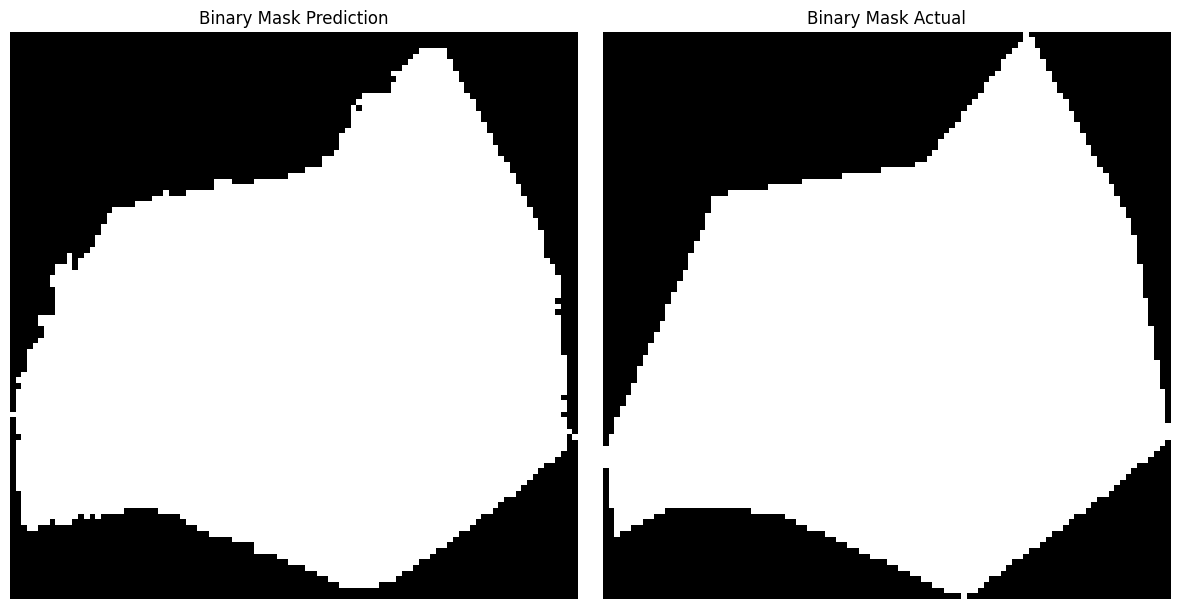

In [40]:
show_example(model_3, 100)

### Bad Loss
Overtrained, but results actually seem ok

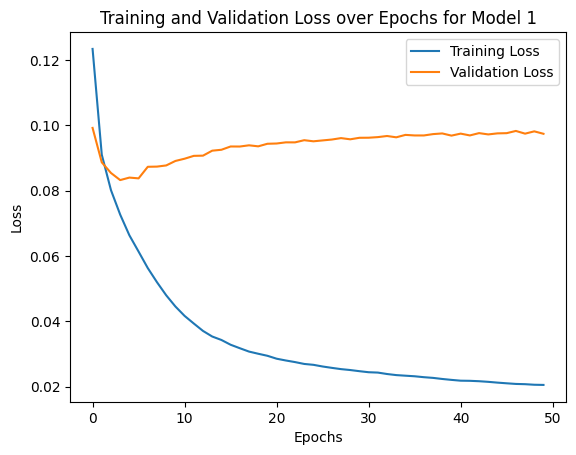

In [42]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs for Model 1')

plt.legend()
plt.show()

_______________________

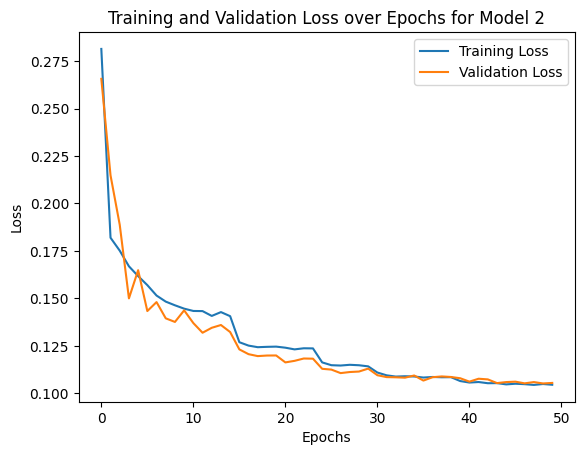

In [43]:
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs for Model 2')

plt.legend()
plt.show()

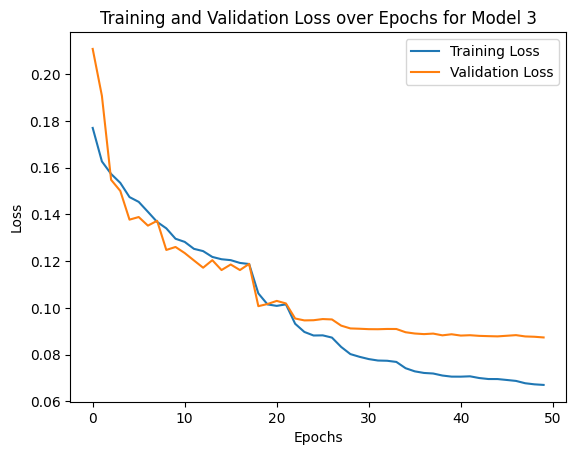

In [44]:
plt.plot(history_3.history['loss'], label='Training Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs for Model 3')

plt.legend()
plt.show()

### Model 3 is the best!